<a href="https://colab.research.google.com/github/akbarlintang/brain-tumor-mri-cnn-gan/blob/main/Brain_Tumor_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import os
from os import listdir

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dataset dari google drive
file_path = "/content/drive/MyDrive/Brain Tumor MRI/brain_tumor_dataset"

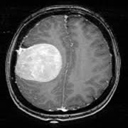

In [ ]:
# Lihat foto tumor dengan label yes
yes_img = Image.open(file_path + "/yes/Y1.jpg").resize((128,128))
yes_img

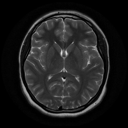

In [ ]:
# Lihat foto tumor dengan label no
no_img = Image.open(file_path + "/no/1 no.jpeg").resize((128,128))
no_img

In [ ]:
# Pointing data sesuai label
yes_files = os.listdir(file_path + "/yes")
no_files = os.listdir(file_path + "/no")

Preprocessing data

In [ ]:
# Install dependency untuk cropping gambar
!pip install imutils
import imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Fungsi untuk crop gambar
def crop_mri(image, plot=False):
    # Ubah gambar kedalam bentuk grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    morph = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    morph = cv2.erode(morph, None, iterations=1)
    morph = cv2.dilate(morph, None, iterations=1)

    # Cari kontur dari gambar yang sudah dimorph, kemudian ambil yang terbesar
    cnts = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Set extreme point
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop gambar dengan 4 extreme point yang sudah diset diatas (left, right, top, bottom)
    cropped = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.subplot(1, 2, 2)
        plt.imshow(cropped)
        plt.title("Cropped Image")
    
    return cropped

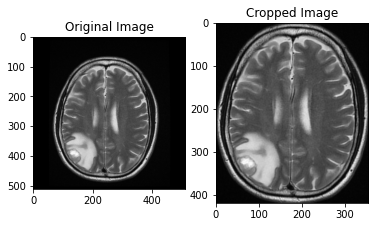

In [ ]:
# Lihat gambar yang sudah dimorphing
ex_img = cv2.imread(file_path+"/yes/Y107.jpg")
prep_img = crop_mri(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_mri(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # Normalisasi gambar
            image = image / 255
            X.append(image)

            # Jika direktori asal memiliki nama 'yes' maka akan diberi label 1,
            # Jika bukan maka diberi label 0
            if(directory[-3:] == 'yes'):
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
file_yes = file_path+"/yes"
file_no = file_path+"/no"

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([file_yes, file_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [ ]:
def plot_images(X, y, n=40):
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n / columns_n)

        plt.figure(figsize=(10,8))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # Menghilangkan tick
            plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1
        # Memberi label yes atau no
        labelName = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain tumor : {labelName(label)}")

        plt.show() 

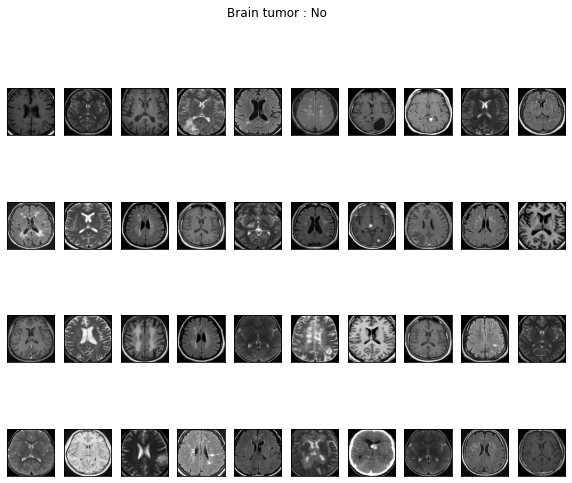

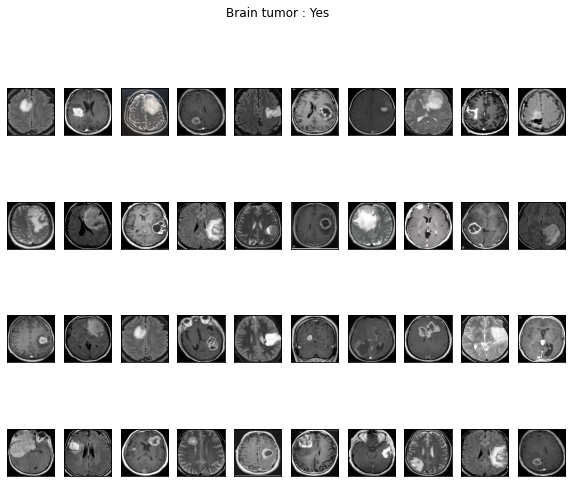

In [ ]:
plot_images(X, y)

In [ ]:
# FUngsi untuk split data training, validasi, dan testing
def split_data(X, y, test_size):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# Panggil fungsi split data dengan parameter data X, y, dan ukuran test sebesar 30% total data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
# Cek jumlah training, validation, dan test sample sebelum augmentasi
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 177
number of validation examples = 38
number of test examples = 38


In [ ]:
# Buat fungsi model CNN
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                           

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
6/6 [==============================] - 17s 3s/step - loss: 1.7719 - accuracy: 0.5537 - val_loss: 0.7080 - val_accuracy: 0.3947
Epoch 2/22
6/6 [==============================] - 16s 3s/step - loss: 0.9769 - accuracy: 0.5593 - val_loss: 0.8991 - val_accuracy: 0.6316
Epoch 3/22
6/6 [==============================] - 18s 3s/step - loss: 0.9476 - accuracy: 0.6836 - val_loss: 0.6693 - val_accuracy: 0.6316
Epoch 4/22
6/6 [==============================] - 16s 3s/step - loss: 0.7249 - accuracy: 0.6497 - val_loss: 0.7725 - val_accuracy: 0.6316
Epoch 5/22
6/6 [==============================] - 16s 3s/step - loss: 0.4785 - accuracy: 0.7853 - val_loss: 0.6502 - val_accuracy: 0.6579
Epoch 6/22
6/6 [==============================] - 16s 3s/step - loss: 0.4633 - accuracy: 0.7853 - val_loss: 0.6425 - val_accuracy: 0.6316
Epoch 7/22
6/6 [==============================] - 16s 3s/step - loss: 0.3946 - accuracy: 0.8418 - val_loss: 0.6322 - val_accuracy: 0.6579
Epoch 8/22
6/6 [==================

In [ ]:
# Catat history model data
history = model.history.history

Plotting akurasi model tanpa augmentasi data

In [ ]:
# Buat fungsi untuk menampilkan plot akurasi
def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Akurasi
    plt.figure()
    plt.plot(train_acc, label='Akurasi Training')
    plt.plot(val_acc, label='Akurasi Validasi')
    plt.title('Akurasi')
    plt.legend()
    plt.show()

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Loss Training')
    plt.plot(val_loss, label='Loss Validasi')
    plt.title('Loss')
    plt.legend()
    plt.show()

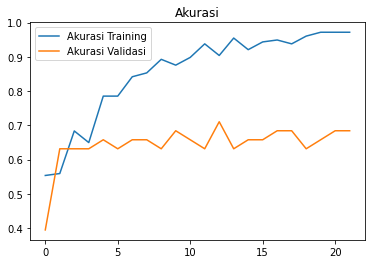

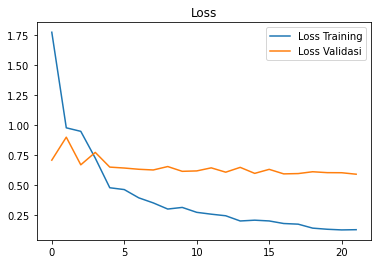

In [ ]:
# Panggil fungsi plotting dengan parameter history pada build model sebelumnya
plot_metrics(history)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

print('\n', 'Akurasi testing adalah: ', score)